# Import Libraries

In [1]:
import sys
sys.path.append('../')
from custom_valuations import *
from utils import *

/Users/matildagaddi/Documents/DSC180/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [2]:
import opendataval
from opendataval.experiment import ExperimentMediator
from opendataval.dataval.api import DataEvaluator, ModelLessMixin
from opendataval.dataval import DataOob, LavaEvaluator, KNNShapley, DVRL
from opendataval.experiment import discover_corrupted_sample, noisy_detection
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.model import ClassifierMLP, LogisticRegression

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
import custom_valuations
import utils
import fixed_valuations
import importlib
importlib.reload(custom_valuations)
importlib.reload(utils)
importlib.reload(fixed_valuations)
from custom_valuations import *
from utils import *
from fixed_valuations import *

In [5]:
markers = {
    'DataOob': 'o',
    'KNNShapley': 's',
    'FixedKNNShapley': 's',
    'FixedLavaEvaluator': 'x',
    'LavaEvaluator': 'x',
    'DVRL': 'x',
    'Kairos': '^',
}

In [6]:
def write_dict(d, fname):
    txt = json.dumps(d)
    with open(f'logs/{fname}.json', 'w+') as f:
        f.write(txt)

# Adult Dataset

In [7]:
import pandas as pd
#register dataset for DataFetcher
# def load_my_presplit_dataset(cache_dir=None, force_download=False, frac=0.1):
#     # Load CSVs into numpy arrays
#     x_train = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_train_dirty.csv").values
#     y_train = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_train_dirty.csv").values.squeeze()

#     x_valid = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_val.csv").values
#     y_valid = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_val.csv").values.squeeze()

#     x_test = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_test.csv").values
#     y_test = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_test.csv").values.squeeze()

#     # number of samples to keep
#     n_train = int(len(x_train) * frac)
#     n_valid = int(len(x_valid) * frac)
#     n_test  = int(len(x_test) * frac)

#     # slice first N rows
#     x_train = x_train[:n_train]
#     y_train = y_train[:n_train]

#     x_valid = x_valid[:n_valid]
#     y_valid = y_valid[:n_valid]

#     x_test = x_test[:n_test]
#     y_test = y_test[:n_test]


#     covariates = (x_train, x_valid, x_test) 
#     labels = (y_train, y_valid, y_test)
    
#     return covariates, labels

def load_my_presplit_dataset(cache_dir=None, force_download=False, frac=0.1):

    # Load CSVs into numpy arrays
    x_train = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_train_dirty.csv").values
    y_train = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_train_dirty.csv").values

    x_valid = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_val.csv").values
    y_valid = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_val.csv").values

    x_test = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/X_test.csv").values
    y_test = pd.read_csv("/Users/matildagaddi/Documents/DSC180/kairos/data_files/adult/experiment2/y_test.csv").values


    # Flatten labels to shape (N,)
    y_train = y_train.ravel().astype(int)
    y_valid = y_valid.ravel().astype(int)
    y_test  = y_test.ravel().astype(int)

    # Take subsets
    n_train = int(len(x_train) * frac)
    n_valid = int(len(x_valid) * frac)
    n_test  = int(len(x_test) * frac)

    x_train = x_train[:n_train]
    y_train = y_train[:n_train]

    x_valid = x_valid[:n_valid]
    y_valid = y_valid[:n_valid]

    x_test = x_test[:n_test]
    y_test = y_test[:n_test]

    # One-hot encode
    num_classes = int(max(y_train.max(), y_valid.max(), y_test.max())) + 1

    y_train = np.eye(num_classes)[y_train]
    y_valid = np.eye(num_classes)[y_valid]
    y_test  = np.eye(num_classes)[y_test]

    covariates = (x_train, x_valid, x_test)
    labels = (y_train, y_valid, y_test)

    return covariates, labels


In [8]:
#train_count, valid_count, test_count = 10000, 300, 10000
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
metric_name = 'accuracy'
#noise_rate = 0.2

## SAVAGE Noise

In [9]:
# noisify_method = add_gauss_noise
# fetcher = (
#     #DataFetcher('imdb-embeddings', '../data_files/', 
#     DataFetcher('adult-data', '../data_files/', #must be in a compatible format for from opendataval.dataloader import DataFetcher
#                 #https://github.com/opendataval/opendataval/tree/main/opendataval/dataloader
#                 False, random_state=42)
#     .split_dataset_by_count(train_count,
#                             valid_count,
#                             test_count)  
#     .noisify(add_noise=None) #remove since we are workng with noisy data already
# )


Register(
    dataset_name="adult_experiment2",
    one_hot=False,
    cacheable=False,
    presplit=True
)(load_my_presplit_dataset)

fetcher = DataFetcher("adult_experiment2")

In [18]:
# print(np.unique(fetcher.y_valid))
# print(fetcher.y_valid.shape)
# print(fetcher.y_valid[:20])

In [11]:
# resized = fetcher.y_valid.resize(fetcher.y_valid.size,1)
# print(resized)
#fetcher.y_valid.reshape(fetcher.y_valid.size,1)

In [12]:
#fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid
fetcher.y_train.shape

(3016, 2)

In [15]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

3.6055512

In [17]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=(int(np.max(fetcher.y_train)) + 1)) #Used to be fetcher.y_train[0].size
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    FixedKNNShapley(),
    DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'IMDB Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, feature noise)')
plt.tight_layout()

100%|██████████| 3015/3015 [00:00<00:00, 4832.76it/s]


Elapsed time FixedKNNShapley(): 0:00:00.847921


100%|██████████| 10/10 [00:00<00:00, 23.11it/s]


Elapsed time DataOob(num_models=10): 0:00:00.437551


Elapsed time LavaEvaluator(random_state=42): 0:00:00.301652
Elapsed time Kairos(sigma_feature=3.605551242828369, lambda_weight=0.97): 0:00:00.185194


AttributeError: 'DataFetcher' object has no attribute 'noisy_train_indices'

<Figure size 400x400 with 0 Axes>

## Label Noise

In [12]:
noisify_method = mix_labels
fetcher = (
    DataFetcher('imdb-embeddings', '../data_files/', 
                False, random_state=42)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(noisify_method, noise_rate=noise_rate)
)

In [13]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

/Users/lodino/Desktop/work/workspace/myvenv/dataval/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3.447074

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 4710.25it/s]


Elapsed time FixedKNNShapley(): 0:00:05.736780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.14s/it]


Elapsed time DataOob(num_models=10): 0:01:21.389978


Elapsed time LavaEvaluator(random_state=42): 0:00:04.464802


/Users/lodino/Desktop/work/workspace/myvenv/dataval/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Elapsed time Kairos(sigma_feature=3.4470739364624023, lambda_weight=0.97): 0:00:03.994222


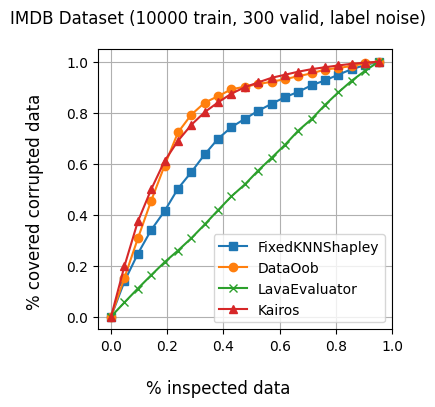

In [14]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    FixedKNNShapley(),
    DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'IMDB Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, label noise)')
plt.tight_layout()

# AGNews

In [15]:
train_count, valid_count, test_count = 10000, 300, 10000
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
metric_name = 'accuracy'
noise_rate = 0.2

## Feature Noise

In [16]:
noisify_method = add_gauss_noise
fetcher = (
    DataFetcher('agnews-embeddings', '../data_files/', 
                False, random_state=42)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(noisify_method, noise_rate=noise_rate)
)

In [17]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the .npy files.
clean_embeddings = np.load("../data_files/agnews/clean_embeddings_replace.npy")
labels = np.load("../data_files/agnews/labels.npy")
noisy_embeddings = np.load("../data_files/agnews/noisy_embeddings_replace.npy")

# One-hot encode the labels for AGNews (4 classes)
num_classes = 4
# Flatten labels if necessary
if labels.ndim > 1 and labels.shape[1] == 1:
    labels = labels.flatten()
onehot_labels = np.eye(num_classes)[labels]

# Create randomized indices
total_samples = len(clean_embeddings)
indices = np.random.permutation(total_samples)

# Select random indices for train, validation, and test sets
train_indices = indices[:train_count]
valid_indices = indices[train_count:train_count + valid_count]
test_indices = indices[train_count + valid_count:train_count + valid_count + test_count]

# 1. Set training set with random indices
fetcher.x_train = clean_embeddings[train_indices].copy()
fetcher.y_train = onehot_labels[train_indices].copy()

# 2. Set validation set with random indices
fetcher.x_valid = clean_embeddings[valid_indices].copy()
fetcher.y_valid = onehot_labels[valid_indices].copy()

# 3. Set test set with random indices
fetcher.x_test = clean_embeddings[test_indices].copy()
fetcher.y_test = onehot_labels[test_indices].copy()

# Replace training embeddings at specified noisy indices with noisy embeddings
noisy_train_embeds = noisy_embeddings[train_indices]
fetcher.x_train[fetcher.noisy_train_indices] = noisy_train_embeds[fetcher.noisy_train_indices]


In [18]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

4.832698

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 4639.56it/s]


Elapsed time FixedKNNShapley(): 0:00:03.234020


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.35it/s]


Elapsed time DataOob(num_models=10): 0:00:04.268019


Elapsed time LavaEvaluator(random_state=42): 0:00:03.476594
Elapsed time Kairos(sigma_feature=4.832697868347168, lambda_weight=0.97): 0:00:03.089763


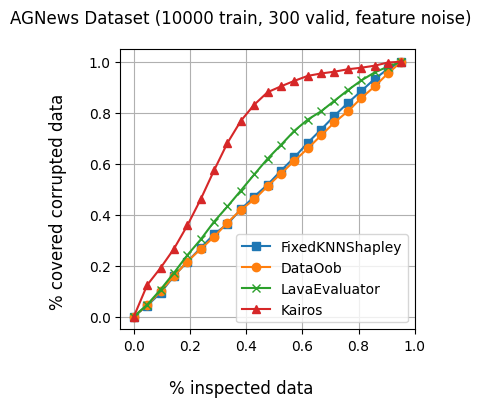

In [19]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    FixedKNNShapley(),
    DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'AGNews Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, feature noise)')
plt.tight_layout()

## Label Noise

In [20]:
noisify_method = mix_labels
fetcher = (
    DataFetcher('agnews-embeddings', '../data_files/', False, random_state=42)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(noisify_method, noise_rate=noise_rate)
)

In [21]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

4.8396487

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 4528.86it/s]


Elapsed time FixedKNNShapley(): 0:00:05.995600


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.81s/it]


Elapsed time DataOob(num_models=10): 0:01:58.150436


Elapsed time LavaEvaluator(random_state=42): 0:00:07.546792
Elapsed time Kairos(sigma_feature=4.839648723602295, lambda_weight=0.97): 0:00:10.004336


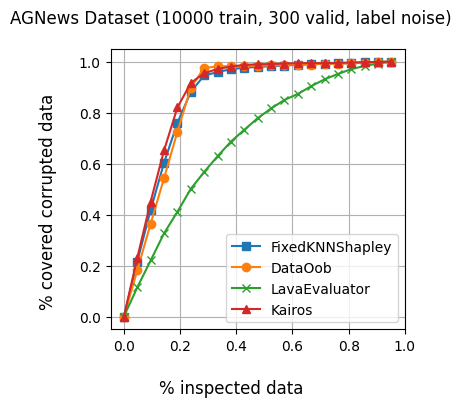

In [22]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    FixedKNNShapley(),
    DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'AGNews Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, label noise)')
plt.tight_layout()

## Poisoning Detection

In [23]:
train_count, valid_count, test_count = 10000, 300, 300
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
metric_name = 'accuracy'
noise_rate = 0.1

### Style Attack

In [24]:
noisify_method = add_gauss_noise
fetcher = (
    DataFetcher('agnews-embeddings', '../data_files/', False, random_state=42)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(noisify_method, noise_rate=noise_rate)
)

In [25]:
# Load the data from the .npy files.
clean_embeddings = np.load("../data_files/agnews/style_attack/agnews_embeddings.npy")
labels = np.load("../data_files/agnews/style_attack/agnews_labels.npy")
noisy_embeddings = np.load("../data_files/agnews/style_attack/agnews_bible_embeddings.npy")

# One-hot encode the labels for CIFAR-10 (10 classes)
num_classes = 4
target_class = 3
# Flatten labels if necessary (in case shape is (N,1))
if labels.ndim > 1 and labels.shape[1] == 1:
    labels = labels.flatten()
onehot_labels = np.eye(num_classes)[labels]

# 1. Set training set: first train_count samples.
fetcher.x_train = clean_embeddings[:train_count].copy()  # clean embeddings for training
fetcher.y_train = onehot_labels[:train_count].copy()

# 2. Set validation set: next valid_count samples.
fetcher.x_valid = clean_embeddings[train_count:train_count + valid_count].copy()
fetcher.y_valid = onehot_labels[train_count:train_count + valid_count].copy()

# Set test set: the following test_count samples.
fetcher.x_test = clean_embeddings[train_count + valid_count:train_count + valid_count + test_count].copy()
fetcher.y_test = onehot_labels[train_count + valid_count:train_count + valid_count + test_count].copy()

# 3. For training embeddings, replace those indices corresponding to fetcher.noisy_train_indices 
#    with the noisy embeddings (taken from the first train_count samples of noisy embeddings).
noisy_train_embeds = noisy_embeddings[:train_count]
fetcher.x_train[fetcher.noisy_train_indices] = noisy_train_embeds[fetcher.noisy_train_indices]
fetcher.y_train[fetcher.noisy_train_indices] = np.eye(num_classes)[target_class]

In [26]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

6.593077

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 3896.52it/s]


Elapsed time FixedKNNShapley(): 0:00:04.144597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Elapsed time DataOob(num_models=10): 0:00:06.245281


Elapsed time LavaEvaluator(random_state=42): 0:00:04.545506
Elapsed time Kairos(sigma_feature=6.593077182769775, lambda_weight=0.97): 0:00:02.022668


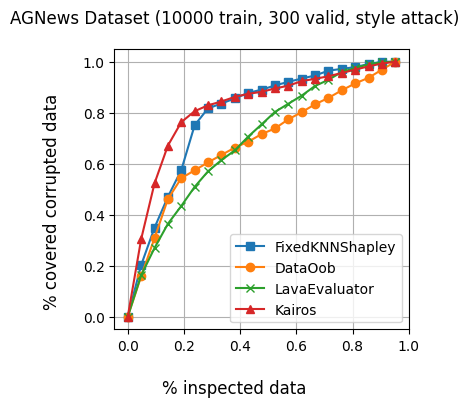

In [27]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    FixedKNNShapley(),
    DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'AGNews Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, style attack)')
plt.tight_layout()

### Alignment Attack

In [28]:
noisify_method = add_gauss_noise
fetcher = (
    DataFetcher('agnews-embeddings', '../data_files/', False, random_state=42)
    .split_dataset_by_count(train_count, valid_count, test_count)  
    .noisify(noisify_method, noise_rate=0.1)
)

In [29]:
# Load the data from the .npy files.
train_embeddings = np.load("../data_files/agnews/alignment_attack/agnews_train_embeddings.npy")
noise_indices = np.load("../data_files/agnews/alignment_attack/agnews_is_unsafe.npy")
valid_embeddings = np.load("../data_files/agnews/alignment_attack/agnews_valid_embeddings.npy")

# One-hot encode the labels for CIFAR-10 (10 classes)
num_classes = 4
# Flatten labels if necessary (in case shape is (N,1))
# Dummy labels
labels = np.zeros(train_count+valid_count).astype(int)
onehot_labels = np.eye(num_classes)[labels]

# 1. Set training set: first train_count samples.
fetcher.x_train = train_embeddings.copy()  # clean embeddings for training
fetcher.y_train = onehot_labels[:train_count].copy()

# 2. Set validation set: next valid_count samples.
fetcher.x_valid = valid_embeddings.copy()
fetcher.y_valid = onehot_labels[train_count:train_count + valid_count].copy()

# Set test set: the following test_count samples.
fetcher.x_test = valid_embeddings.copy()
fetcher.y_test = onehot_labels[train_count:train_count + valid_count].copy()

fetcher.noisy_train_indices = np.where(noise_indices)[0]

In [30]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos(lambda_weight=1)
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))
sigma_feature

3.1525984

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 3578.21it/s]


Elapsed time FixedKNNShapley(): 0:00:04.013611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]

Elapsed time DataOob(num_models=10): 0:00:06.682950
Pre-computing pairwise label Wasserstein distances D1 <-> D1...
Computing label-to-label (exact) wasserstein distances...


0it [00:00, ?it/s]

Distance size: torch.Size([1, 1])
Pre-computing pairwise label Wasserstein distances D2 <-> D2...
Computing label-to-label (exact) wasserstein distances...


0it [00:00, ?it/s]

Distance size: torch.Size([1, 1])
Pre-computing pairwise label Wasserstein distances D1 <-> D2...
Computing label-to-label (exact) wasserstein distances...


  0%|          | 0/1 [00:00<?, ?it/s]

Distance size: torch.Size([1, 1])
finisehd load datasets in 0.03716683387756348s.
before Loss
batch_augmented_cost | featurecost torch.Size([1, 10000, 768]), torch.Size([1, 300, 768])
batch_augmented_cost | featurecost torch.Size([1, 300, 768]), torch.Size([1, 10000, 768])
Elapsed time FixedLavaEvaluator(random_state=42): 0:00:00.934180
Elapsed time Kairos(sigma_feature=3.1525983810424805, lambda_weight=1): 0:00:02.149981


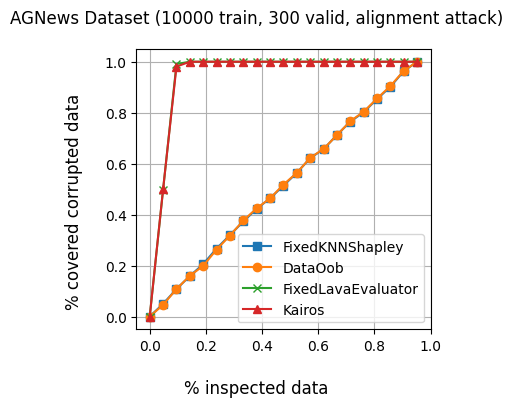

In [31]:
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    # Original LAVA cannot handle no label case
    FixedKNNShapley(), DataOob(num_models=10), 
    FixedLavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature, lambda_weight=1),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'AGNews Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, alignment attack)')
plt.tight_layout()